In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
params_dict_mu = {
    'input_size': 3,
    'hidden_size': 10,
    'output_size': 3,
    'ode_nn': ((50, "tanh"), (50, "tanh")),
    'readout_nn': ((50, "tanh"), (50, "tanh")),
    'enc_nn': ((50, "tanh"), (50, "tanh")),
    'use_rnn': False,
    'options': {'which_loss': 'easy'},
    "input_coords": np.arange(3),
    "output_coords": np.arange(3)
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from models import get_ckpt_model, NJODE
model_mu = NJODE(**params_dict_mu).to(device)
optimizer = torch.optim.Adam(model_mu.parameters())
get_ckpt_model("../data/saved_models/id-51/last_checkpoint/", model_mu, optimizer, device)
model_mu.eval()

using loss: easy
neuralODE use input scaling with tanh
use residual network: input_size=3, output_size=10
use residual network: input_size=10, output_size=3


NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=15, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
 

In [54]:
params_dict_vol = {
    'input_size': 9,
    'hidden_size': 10,
    'output_size': 9,
    'ode_nn': ((50, "tanh"), (50, "tanh")),
    'readout_nn': ((50, "tanh"), (50, "tanh")),
    'enc_nn': ((50, "tanh"), (50, "tanh")),
    'use_rnn': False,
    'options': {'which_loss': 'easy_vol'},
    "input_coords": np.arange(9),
    "output_coords": np.arange(9)
}
model_vol = NJODE(**params_dict_vol).to(device)
optimizer_vol = torch.optim.Adam(model_vol.parameters())
get_ckpt_model("../data/saved_models/id-53/last_checkpoint/", model_vol, optimizer_vol, device)
model_vol.eval()

using loss: easy_vol
neuralODE use input scaling with tanh
use residual network: input_size=9, output_size=10
use residual network: input_size=10, output_size=9


NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=21, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=9, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
 

In [55]:
mu_data=np.load("../data/training_data/OrnsteinUhlenbeckMultiDimensional-46/data.npy")

In [52]:
vol_data=np.load("../data/training_data/OrnsteinUhlenbeckForZ-49/data.npy")

In [5]:
 def generate_next_value( X_t, mu_t, sigma_t, delta_t):
    """
    Generate the next value in the time series using the Euler-Maruyama scheme.

    :param X_t: current value tensor of shape (batch_size, d)
    :param mu_t: drift coefficient tensor of shape (batch_size, d)
    :param sigma_t: diffusion coefficient tensor of shape ( d, d)
    :param delta_t: time difference float
    :return: next value tensor of shape (batch_size, d)
    """
    delta_Wt = torch.randn_like(X_t) * delta_t** 0.5

    X_t_next = X_t + mu_t * delta_t + delta_Wt @ sigma_t

    return X_t_next

In [57]:
times=np.array([])
time_ptr = np.array([0])
obs_idx = torch.tensor([],dtype=torch.long)
start_Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
delta_t=0.01
X= torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
start_X = torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
n_obs_ot=torch.tensor([0], dtype=torch.float)

for i in range(1,101): 
    T=0.01*i
    mu_pred=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1] 
    X_t = X[i-1,:].unsqueeze(0) 
    if i>1: 
        X_t_minus = X[i-2, :].unsqueeze(0)
        Z_tensor = (X_t - X_t_minus).T@(X_t-X_t_minus)
        Z=torch.cat((Z,Z_tensor.view(1,-1)))
    sigma_pred=model_vol.get_pred(times, time_ptr, Z, obs_idx, delta_t, T, start_Z, n_obs_ot )["pred"][-1]
    
    mu_hat_t = (mu_pred - X_t)/delta_t
    sigma_hat_t = sigma_pred/(delta_t**0.5)
    X_next = generate_next_value(X_t, mu_hat_t, sigma_hat_t.view(3,3), delta_t)
    X= torch.cat((X,X_next))
    times=np.append(times, 0.01*i)
    time_ptr = np.append(time_ptr, i) 
    obs_idx=torch.cat((obs_idx, torch.tensor([0], dtype=torch.long)))
    n_obs_ot+=1

In [58]:
X

tensor([[1.0000, 1.5000, 2.0000],
        [0.9957, 1.5100, 2.0228],
        [1.0299, 1.5166, 1.9906],
        [0.9791, 1.5093, 2.0173],
        [1.0421, 1.5135, 2.0048],
        [0.9751, 1.5482, 2.0455],
        [1.0473, 1.4945, 1.9978],
        [0.9825, 1.5568, 2.0740],
        [1.0345, 1.5195, 2.0206],
        [0.9297, 1.4839, 2.0083],
        [1.0561, 1.5408, 2.0414],
        [0.9491, 1.4796, 2.0130],
        [1.0548, 1.5599, 2.0148],
        [0.9245, 1.5025, 2.0211],
        [1.0393, 1.5783, 2.0449],
        [0.9148, 1.4824, 2.0052],
        [1.0570, 1.5619, 2.0424],
        [0.9152, 1.4714, 1.9999],
        [1.0714, 1.5611, 2.0151],
        [0.9452, 1.5054, 2.0182],
        [1.1068, 1.6026, 2.0477],
        [0.9238, 1.5216, 2.0369],
        [1.0526, 1.5470, 2.0017],
        [0.7660, 1.4380, 1.9355],
        [1.0941, 1.5722, 2.0229],
        [0.8037, 1.4753, 1.9682],
        [1.1269, 1.5596, 2.0319],
        [0.8294, 1.4720, 1.9430],
        [1.0619, 1.5583, 2.0188],
        [0.997

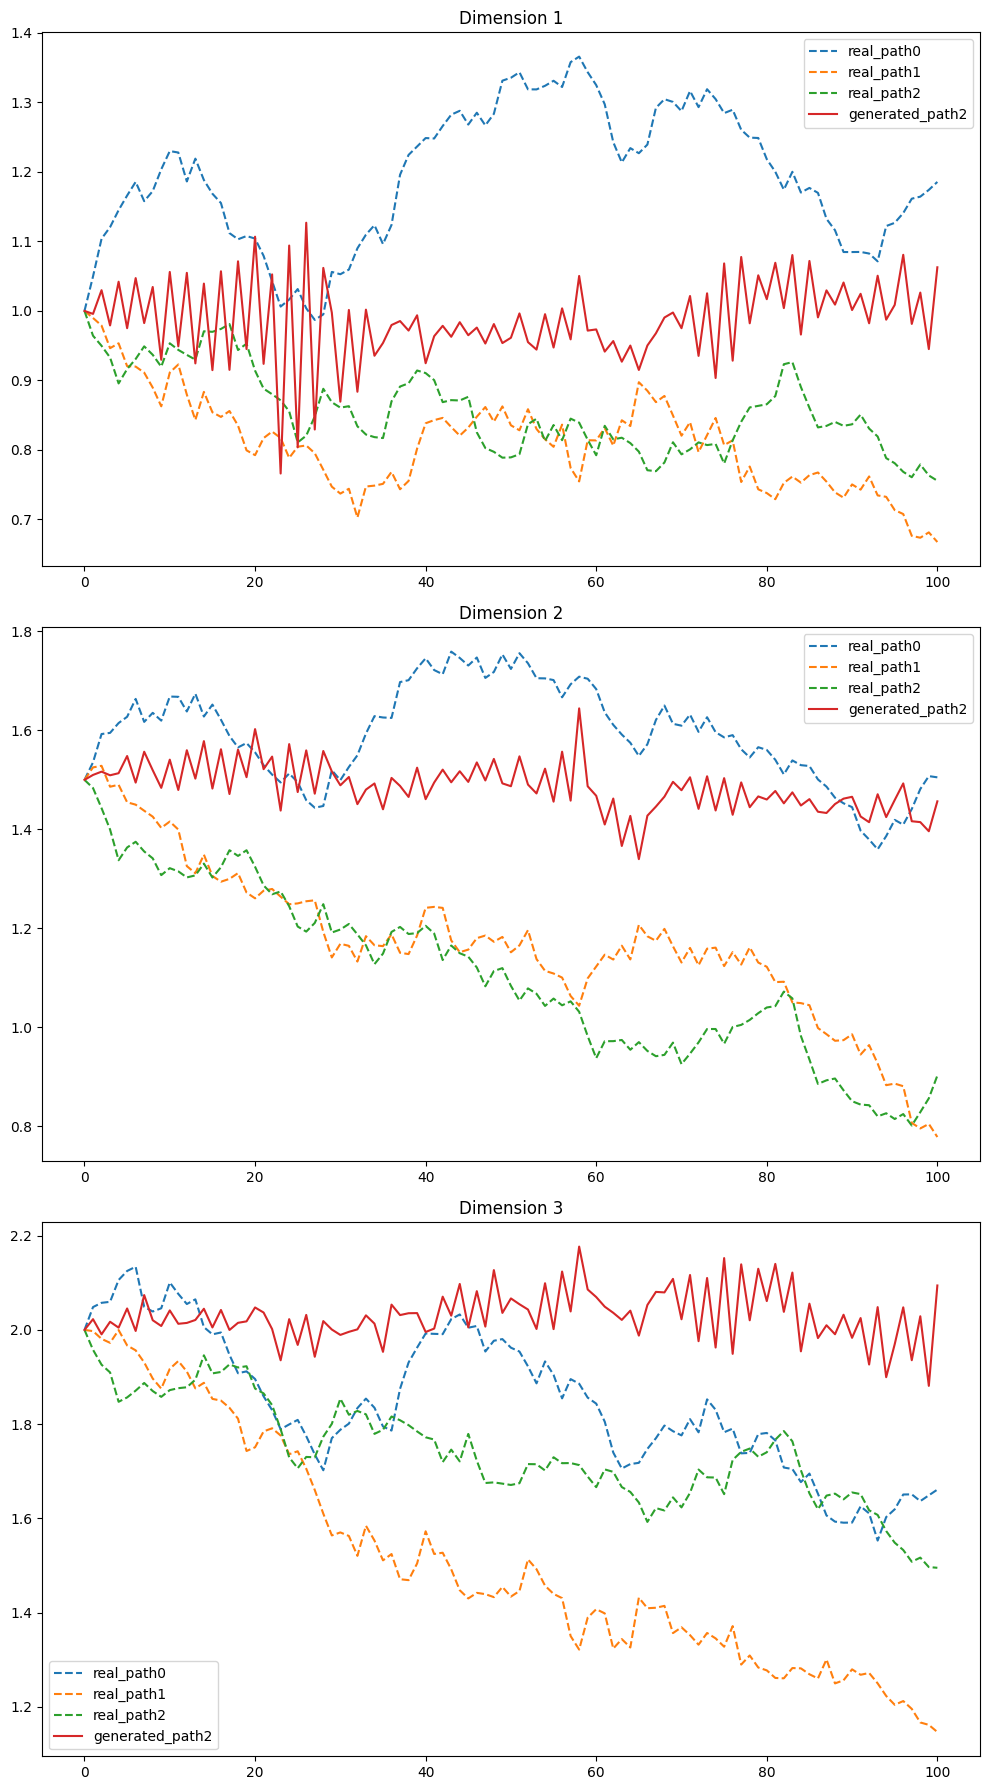

In [60]:
# Plotting each dimension separately
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    real_path = mu_data[:, i, :].T
    generated_path = X[:, i]

    for j in range(3):
        axs[i].plot(real_path[:, j], label=f'real_path{j}', linestyle="--")

    axs[i].plot(generated_path.unsqueeze(1).detach().numpy(), label=f'generated_path{j}')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

In [27]:
times=np.array([0.01,])
time_ptr = np.array([0, 1])
obs_idx = torch.tensor([0],dtype=torch.long)
Vol = torch.tensor([],dtype=torch.float)
delta_t=0.01
X= torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
start_X = torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
n_obs_ot=torch.tensor([1], dtype=torch.float)

for i in range(2,3):
    times=np.append(times, 0.01*i)
    time_ptr = np.append(time_ptr, i)
    T=0.01*i
    obs_idx=torch.cat((obs_idx, torch.tensor([0], dtype=torch.long)))
    n_obs_ot+=1
    X= torch.cat((X, torch.tensor(mu_data[0,:,i-1], dtype=torch.float).unsqueeze(0)))

    # Here mu_pred is conditional expectation of X_t at time 0.01*(i-1)
    mu_pred=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1]
    print(model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot))
    X_t_plus = X[i-1,:].unsqueeze(0)
    X_t = X[i-2, :].unsqueeze(0)
    vol_tensor = (X_t_plus - X_t).T@(X_t_plus-X_t)
    if i==2:
        start_Vol = vol_tensor.view(1,-1)
    vol  = vol_tensor.view(1,-1)
    Vol = torch.cat((Vol, vol))

    # Here sigma_pred conditional expectation of Z_t at time 0.01*(i-2) 
    sigma_pred=model_vol.get_pred(times[:-1], time_ptr[:-1], Vol, obs_idx[:-1], delta_t, T, start_Vol, (n_obs_ot-1) )["pred"][-1]

    # Computed mu_hat and sigma_hat at time 0.01*(i-2) 
    mu_hat_t = (mu_pred - X_t)/delta_t
    sigma_hat_t = sigma_pred/delta_t

    # generated new point at time 0.01*(i-1) 
    X_next = generate_next_value(X_t, mu_hat_t, sigma_hat_t.view(3,3), delta_t)
    res_sm_add = stockmodel.compute_cond_exp( times, time_ptr, X.detach().numpy(), obs_idx.detach().numpy(),delta_t, T, start_X.detach().numpy(), n_obs_ot.detach().numpy())
    print(res_sm_add)
    
    print(stockmodel.next_cond_exp(X_t.detach().numpy(),delta_t,T))
    print(stockmodel.next_cond_exp(X_t_plus.detach().numpy(),delta_t,T))
    # Replace the old real data at time 0.01*(i-1) with generated data 
    X[i-1,:] = X_next
    
    print(X_next)

{'pred': tensor([[[1.0001, 1.5001, 2.0001]],

        [[1.0002, 1.4996, 1.9995]],

        [[1.0001, 1.5001, 2.0001]],

        [[1.0002, 1.4996, 1.9995]],

        [[1.0497, 1.5355, 2.0486]]], grad_fn=<SliceBackward0>), 'pred_t': array([0.  , 0.01, 0.01, 0.02, 0.02]), 'loss': tensor(0.0031, grad_fn=<AddBackward0>)}
(None, array([0.  , 0.01, 0.01, 0.02, 0.02]), array([[[1.        , 1.5       , 2.        ]],

       [[1.0005991 , 1.49800399, 1.99750624]],

       [[1.        , 1.5       , 2.        ]],

       [[1.0005991 , 1.49800399, 1.99750624]],

       [[1.36035633, 1.90672851, 2.63033485]]]))
[[1.0005991  1.49800399 1.99750624]]
[[1.0501203  1.53329441 2.04576868]]
tensor([[1.1713, 1.6846, 2.2169]], grad_fn=<AddBackward0>)


In [18]:
X_t_plus

tensor([[1.3169, 1.7767, 2.5967]], grad_fn=<AsStridedBackward0>)

In [6]:
import data_utils

param_dict: {'epochs': [200], 'batch_size': [200], 'save_every': [5], 'learning_rate': [0.001], 'test_size': [0.2], 'seed': [398], 'hidden_size': [10], 'bias': [True], 'dropout_rate': [0.1], 'ode_nn': [((50, 'tanh'), (50, 'tanh'))], 'readout_nn': [((50, 'tanh'), (50, 'tanh'))], 'enc_nn': [((50, 'tanh'), (50, 'tanh'))], 'use_rnn': [False], 'func_appl_X': [[]], 'solver': ['euler'], 'weight': [0.5], 'weight_decay': [1.0], 'dataset': ['BlackScholes', 'Heston', 'OrnsteinUhlenbeck'], 'dataset_id': [None], 'plot': [True], 'evaluate': [True], 'paths_to_plot': [(0, 1, 2, 3, 4)]}
param_dict: {'epochs': [100], 'batch_size': [20], 'save_every': [10], 'learning_rate': [0.001], 'test_size': [0.2], 'training_size': [200, 400, 800, 1600, 3200, 6400, 12800], 'seed': [398], 'hidden_size': [10], 'bias': [True], 'dropout_rate': [0.1], 'ode_nn': [((10, 'tanh'), (10, 'tanh'))], 'readout_nn': [((10, 'tanh'), (10, 'tanh'))], 'enc_nn': [((10, 'tanh'), (10, 'tanh'))], 'use_rnn': [False], 'func_appl_X': [[]], 's

In [8]:
stockmodel = data_utils._STOCK_MODELS[dataset_metadata['model_name']](**dataset_metadata)

In [ ]:
stockmodel

In [7]:
dataset_metadata = data_utils.load_metadata(stock_model_name="OrnsteinUhlenbeckMultiDimensional", time_id=46)

In [ ]:
dataset_metadata